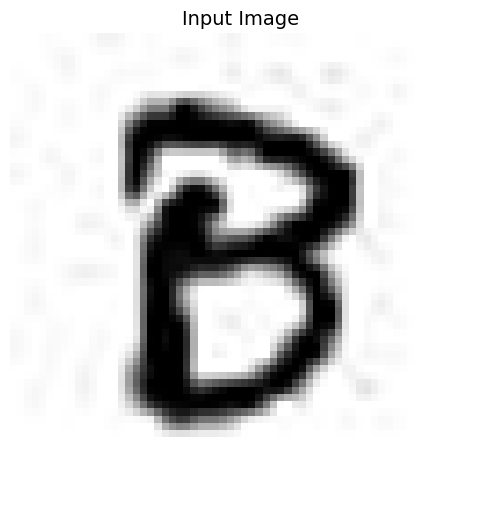

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image
from scipy.signal import convolve2d

# --------------------------------------------------
# Setup
# --------------------------------------------------
os.makedirs("gifs", exist_ok=True)

# --------------------------------------------------
# Load real grayscale image
# --------------------------------------------------
img = Image.open(".\Images\B.jpg").convert("L")
img = img.resize((64, 64))
x = np.array(img, dtype=float) / 255.0

# --------------------------------------------------
# CNN utility functions
# --------------------------------------------------
def conv2d(img, kernel):
    return convolve2d(img, kernel, mode="valid")

def relu(x):
    return np.maximum(0, x)

def maxpool(x, size=2):
    h, w = x.shape

    # Trim to multiples of pool size
    h_trim = (h // size) * size
    w_trim = (w // size) * size

    x = x[:h_trim, :w_trim]

    pooled = np.zeros((h_trim // size, w_trim // size))

    for i in range(0, h_trim, size):
        for j in range(0, w_trim, size):
            pooled[i//size, j//size] = np.max(x[i:i+size, j:j+size])

    return pooled


# --------------------------------------------------
# Define convolution kernels (learned-like filters)
# --------------------------------------------------
kernels = [
    np.array([[1, 0, -1],
              [1, 0, -1],
              [1, 0, -1]]),          # vertical edges

    np.array([[1, 1, 1],
              [0, 0, 0],
              [-1,-1,-1]]),          # horizontal edges

    np.array([[0, -1, 0],
              [-1, 4, -1],
              [0, -1, 0]])           # corners
]

# --------------------------------------------------
# CNN forward pass (block by block)
# --------------------------------------------------
stages = []
titles = []

# Input
stages.append(x)
titles.append("Input Image")

# -------- Block 1 --------
f1 = sum(conv2d(x, k) for k in kernels)
a1 = relu(f1)
p1 = maxpool(a1)
stages.extend([a1, p1])
titles.extend(["Conv Block 1 (ReLU)", "MaxPool 1"])

# -------- Block 2 --------
f2 = sum(conv2d(p1, k) for k in kernels)
a2 = relu(f2)
p2 = maxpool(a2)
stages.extend([a2, p2])
titles.extend(["Conv Block 2 (ReLU)", "MaxPool 2"])

# -------- Block 3 --------
f3 = sum(conv2d(p2, k) for k in kernels)
a3 = relu(f3)
stages.append(a3)
titles.append("Conv Block 3 (ReLU)")

# --------------------------------------------------
# Normalize stages for visualization
# --------------------------------------------------
def normalize(img):
    img = img - img.min()
    if img.max() != 0:
        img = img / img.max()
    return img

stages = [normalize(s) for s in stages]

# --------------------------------------------------
# Animation setup
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis("off")

im = ax.imshow(stages[0], cmap="gray")
title = ax.set_title(titles[0], fontsize=14)

def init():
    im.set_data(stages[0])
    title.set_text(titles[0])
    return [im, title]

def update(i):
    im.set_data(stages[i])
    title.set_text(titles[i])
    return [im, title]

ani = FuncAnimation(
    fig,
    update,
    frames=len(stages),
    init_func=init,
    interval=1200,
    blit=False
)



In [ ]:
# Force first frame render (critical for saving)
init()
update(0)
fig.canvas.draw()

# Save GIF
ani.save("gifs/cnn_multi_block_network.gif", writer="pillow")

plt.show()
